In [1]:
import csv_to_sqlite 
import sqlite3
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## working listing file

In [2]:
# Load data
df = pd.read_csv('../raw_data/listings.csv')

# No needed columns
columns_todrop = ['id',
                  'listing_url',
                  'scrape_id',
                  'name',
                  'description',
                  'neighborhood_overview',
                  'picture_url',
                  'host_id',
                  'host_url',
                  'host_name',
                  'host_location',
                  'host_about',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_verifications',
                  'neighbourhood',
                  'neighbourhood_group_cleansed',
                  'calendar_last_scraped',
                  'bathrooms',
                  'calendar_updated',
                  'license',
                  'host_response_time',
                  'host_response_rate',
                  'host_acceptance_rate',
                  'bathrooms_text',
                  'host_neighbourhood',
                  'last_review'
                 ]
df = df.drop(columns=columns_todrop)

# Converting Amenities from str to list
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['total_amenities'] = df['amenities'].apply(lambda x: len(x))

# Droping null - subset: host since 
df.dropna(subset=['host_since'],inplace=True)

# Formating to datetime
df[['host_since','first_review','last_scraped']] = df[['host_since','first_review','last_scraped']].apply(pd.to_datetime)

# Calculating Host Tenure
df['host_tenure'] = (df['last_scraped'] - df['host_since']).dt.days

# Formating Price
df['price'] = df['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

# Reseting Index
df.reset_index(drop=True,inplace=True)


In [3]:
reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns]
df_reg.head(10)

,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,neighbourhood_cleansed,price
0,51.56861,-0.11270,Private room,2,1.0,NaN,1,Islington,65.0
1,51.48780,-0.16813,Entire home/apt,2,1.0,1.0,3,Kensington and Chelsea,75.0
2,51.52195,-0.14094,Entire home/apt,6,3.0,3.0,4,Westminster,265.0
3,51.47935,-0.19743,Private room,2,1.0,1.0,3,Hammersmith and Fulham,150.0
4,51.57438,-0.21081,Private room,2,1.0,NaN,10,Barnet,29.0
5,51.46416,-0.32554,Private room,2,1.0,1.0,2,Hounslow,65.0
6,51.48085,-0.28086,Entire home/apt,5,3.0,3.0,3,Richmond upon Thames,195.0
7,51.58478,-0.16057,Private room,2,1.0,NaN,2,Haringey,72.0
8,51.41844,-0.08729,Private room,2,1.0,NaN,1,Croydon,65.0
9,51.50701,-0.23362,Entire home/apt,8,4.0,4.0,30,Hammersmith and Fulham,190.0


In [4]:
df_reg.isnull().sum()/len(df_reg)*100

latitude                  0.000000
longitude                 0.000000
room_type                 0.000000
accommodates              0.000000
bedrooms                  6.024151
beds                      5.466943
minimum_nights            0.000000
neighbourhood_cleansed    0.000000
price                     0.000000
dtype: float64

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 # visualizing pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

In [6]:
X = df_reg.drop(columns='price')
y = df_reg['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('encoding', cat_transformer, ['room_type','neighbourhood_cleansed']),
    ('imputer', KNNImputer(missing_values=np.nan),['bedrooms','beds'])],
    remainder='passthrough')

In [9]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoding',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['room_type', 'neighbourhood_cleansed']),
                                ('imputer', KNNImputer(),
                                 ['bedrooms', 'beds'])])

In [10]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model',LinearRegression())
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('imputer', KNNImputer(),
                                                  ['bedrooms', 'beds'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [11]:
pipe.fit(X_train,y_train)
pipe.score(X_train,y_train)

0.07874037369689924

In [12]:
y_pred = pipe.predict(X_train)
mean_squared_error(y_train, y_pred,squared=False)

315.107607763427

In [13]:
pipe.score(X_test,y_test)

0.056744042530647354

In [14]:
y_pred = pipe.predict(X_test)
mean_squared_error(y_test, y_pred,squared=False)

384.7592592874731

In [15]:
import pickle

# Export pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipe, file )

## Model exploration 

### Correlations

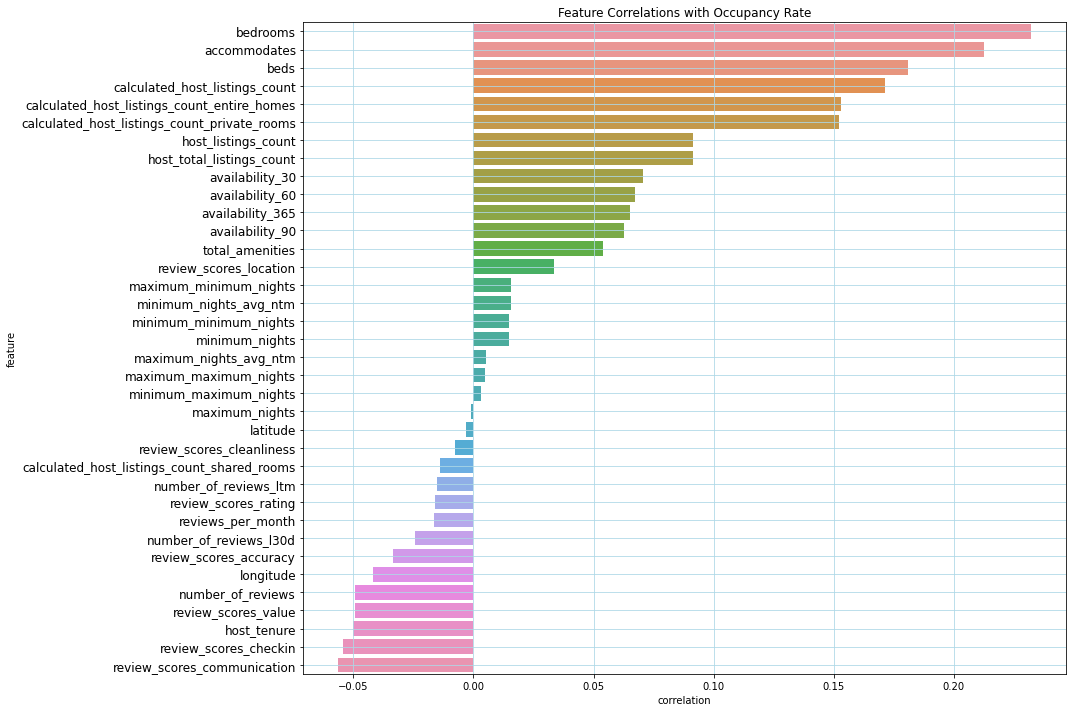

In [16]:
or_corr = pd.DataFrame(df.corrwith(df['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Occupancy Rate', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

In [17]:
import statsmodels.formula.api as smf

In [26]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [93]:
reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns].copy()
df_reg.head(5)

,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,neighbourhood_cleansed,price
0,51.56861,-0.11270,Private room,2,1.0,NaN,1,Islington,65.0
1,51.48780,-0.16813,Entire home/apt,2,1.0,1.0,3,Kensington and Chelsea,75.0
2,51.52195,-0.14094,Entire home/apt,6,3.0,3.0,4,Westminster,265.0
3,51.47935,-0.19743,Private room,2,1.0,1.0,3,Hammersmith and Fulham,150.0
4,51.57438,-0.21081,Private room,2,1.0,NaN,10,Barnet,29.0


In [94]:
# Imputing Bedrooms and Beds
imputer_bedroom = KNNImputer(missing_values=np.nan)
imputer_bed = KNNImputer(missing_values=np.nan)

df_reg['bedrooms'] = imputer_bedroom.fit_transform(df[['bedrooms']])
df_reg['beds'] = imputer_bed.fit_transform(df[['beds']])

In [95]:
df_reg.isnull().sum()/len(df_reg)*100

latitude                  0.0
longitude                 0.0
room_type                 0.0
accommodates              0.0
bedrooms                  0.0
beds                      0.0
minimum_nights            0.0
neighbourhood_cleansed    0.0
price                     0.0
dtype: float64

In [96]:
df_reg.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [97]:
encoder_room_type = OneHotEncoder(sparse=False)
room_type_encoded = pd.DataFrame(encoder_room_type.fit_transform(df_reg[['room_type']]))
room_type_encoded.columns=[x.replace(' ','_').replace('/','_') for x in encoder_room_type.categories_[0].tolist()]

In [98]:
df_reg = pd.concat([df_reg, room_type_encoded], axis=1)
df_reg.drop(columns=['room_type','neighbourhood_cleansed'], inplace=True)
df_reg.head(5)

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,price,Entire_home_apt,Hotel_room,Private_room,Shared_room
0,51.56861,-0.11270,2,1.0,1.758031,1,65.0,0.0,0.0,1.0,0.0
1,51.48780,-0.16813,2,1.0,1.000000,3,75.0,1.0,0.0,0.0,0.0
2,51.52195,-0.14094,6,3.0,3.000000,4,265.0,1.0,0.0,0.0,0.0
3,51.47935,-0.19743,2,1.0,1.000000,3,150.0,0.0,0.0,1.0,0.0
4,51.57438,-0.21081,2,1.0,1.758031,10,29.0,0.0,0.0,1.0,0.0


In [57]:
encoder_neighbourhood = OneHotEncoder(sparse=False)
neighbourhood_encoded = pd.DataFrame(encoder_neighbourhood.fit_transform(df_reg[['neighbourhood_cleansed']]))
neighbourhood_encoded.columns=[x.replace(' ','_') for x in encoder_neighbourhood.categories_[0].tolist()]

In [80]:
df_reg = pd.concat([df_reg, neighbourhood_encoded], axis=1)
df_reg.drop(columns=['room_type','neighbourhood_cleansed'], inplace=True)
df_reg.head(5)

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,price,Barking_and_Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City_of_London,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith_and_Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington_and_Chelsea,Kingston_upon_Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond_upon_Thames,Southwark,Sutton,Tower_Hamlets,Waltham_Forest,Wandsworth,Westminster
0,51.56861,-0.11270,2,1.0,1.758031,1,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,51.48780,-0.16813,2,1.0,1.000000,3,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.52195,-0.14094,6,3.0,3.000000,4,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,51.47935,-0.19743,2,1.0,1.000000,3,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51.57438,-0.21081,2,1.0,1.758031,10,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


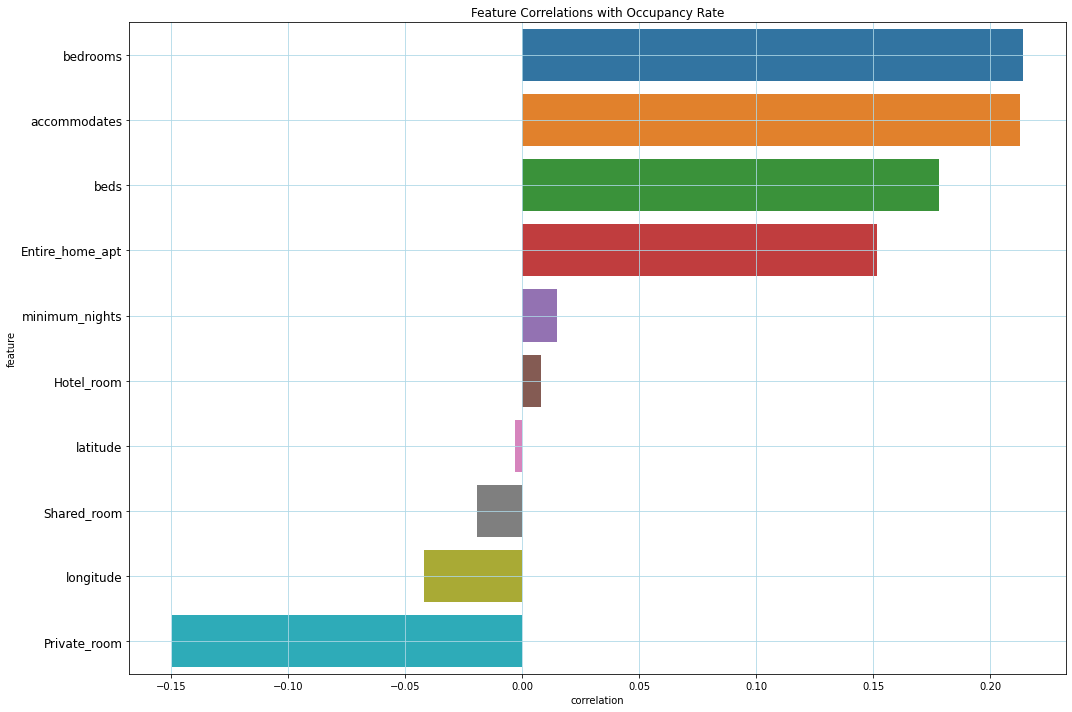

In [99]:
or_corr = pd.DataFrame(df_reg.corrwith(df_reg['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Occupancy Rate', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

In [117]:
scaler = StandardScaler()
df_reg_scaled = pd.DataFrame(scaler.fit_transform(df_reg), columns=list(df_reg.columns))

In [118]:
model = smf.ols(formula = formula_from_cols(df_reg_scaled,'price'), data=df_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     422.9
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:52:00   Log-Likelihood:            -4.8267e+05
No. Observations:               66582   AIC:                         9.654e+05
Df Residuals:                   66572   BIC:                         9.654e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1180.8374   1133.494     -1.042      0.298   -3402.486    1040.811
latitude           28.8839     27.500      1.050      0.294     -25.017      82.785
longitude        -108.4552     13.686     -7.925      0.000    -135.279     -81.632
accommodates       18.1846      1.417     12.835      0.000      15.408      20.961
bedrooms           51.3359      2.769     18.541      0.000      45.909      56.763
beds               -5.5539      1.978     -2.808      0.005      -9.431      -1.677
minimum_nights      0.1892      0.044      4.348      0.000       0.104       0.275
Entire_home_apt  -282.6201    283.359     -0.997      0.319    -838.003     272.763
Hotel_room       -247.4508    284.129     -0.871      0.384    -804.343     309.442
Private_room     -318.5466    283.340     -1.124      0.261    -873.893     236.800
Shared_room      -332.2199    283.587     -1.171      0.241    -888.049     223.610
==============================================================================
Omnibus:                   158166.048   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2314253121.363
Skew:                          24.150   Prob(JB):                         0.00
Kurtosis:                     915.062   Cond. No.                     1.39e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.39e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""